Using *Qiskit* for implementing **Quantum Support Vector Machine** and compairing the results with linear kernel Support Vector machine

# Installing Quantum Packges

In [117]:
!pip install qiskit
!pip install qiskit-machine-learning

Importing Classical Modules and Quantum Modules

In [118]:
#CLASSICAL IMPORTS
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns

#QUANTUM IMPORTS
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC


# Data Preprocessing

In [176]:
input = pd.read_csv('/content/pulsar_data_train.csv')

In [177]:
input = input.head(350)
input.fillna(5, inplace=True)

<ipython-input-177-a821bf26dfe7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input.fillna(5, inplace=True)


In [178]:
y = input.pop("target_class")

In [179]:
y

,target_class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
345,0.0
346,0.0
347,0.0
348,0.0


In [180]:
input

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,5.000000,2.958066,7.197842
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128
...,...,...,...,...,...,...,...,...
345,124.132812,60.765864,5.000000,-1.185706,2.124582,5.000000,12.060996,170.937531
346,104.750000,44.374824,0.300412,0.289506,0.968227,11.039106,17.036354,341.225060
347,128.523438,51.301798,0.047370,-0.288825,3.565217,5.000000,7.369965,60.303536
348,122.945312,43.367850,0.198347,0.713728,3.399666,24.310852,7.603948,59.014093


<Axes: >

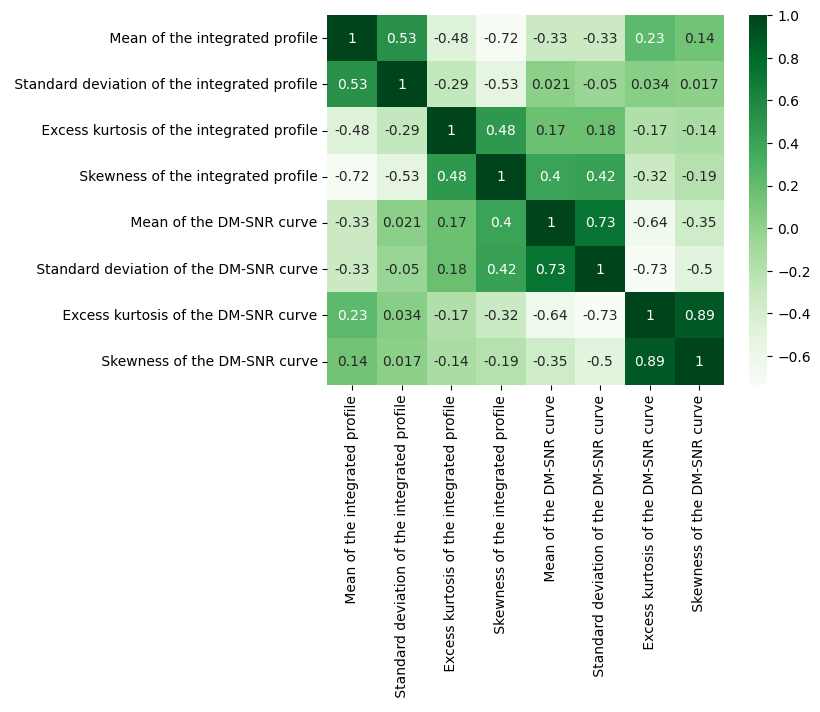

In [181]:

corelation_matrix = input.corr()
sns.heatmap(corelation_matrix, cmap="Greens", annot=True)


Data that have corelation more than .6 or less than -.6 we are going to remove them.
They are -
1. *Skewness of the integrated profile*
2. *Standard deviation of the DM-SNR curve*
3. *Skewness of the DM-SNR curve*

In [182]:
list_of_column_names = list(input.columns)

In [183]:
list_of_column_names

[' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve']

In [184]:
input = input.drop(' Excess kurtosis of the DM-SNR curve', axis=1)
input = input.drop(' Standard deviation of the DM-SNR curve', axis=1)
input = input.drop(' Skewness of the integrated profile', axis=1)

In [185]:
input

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Mean of the DM-SNR curve,Skewness of the DM-SNR curve
0,121.156250,48.372971,0.375485,3.168896,65.159298
1,76.968750,36.175557,0.712898,2.399666,102.722975
2,130.585938,53.229534,0.133408,2.743311,74.031324
3,156.398438,48.865942,-0.215989,17.471572,7.197842
4,84.804688,36.117659,0.825013,2.790134,76.291128
...,...,...,...,...,...
345,124.132812,60.765864,5.000000,2.124582,170.937531
346,104.750000,44.374824,0.300412,0.968227,341.225060
347,128.523438,51.301798,0.047370,3.565217,60.303536
348,122.945312,43.367850,0.198347,3.399666,59.014093


<ipython-input-186-6a414bb9165c>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist = input.hist(bins=100, ax= ax)


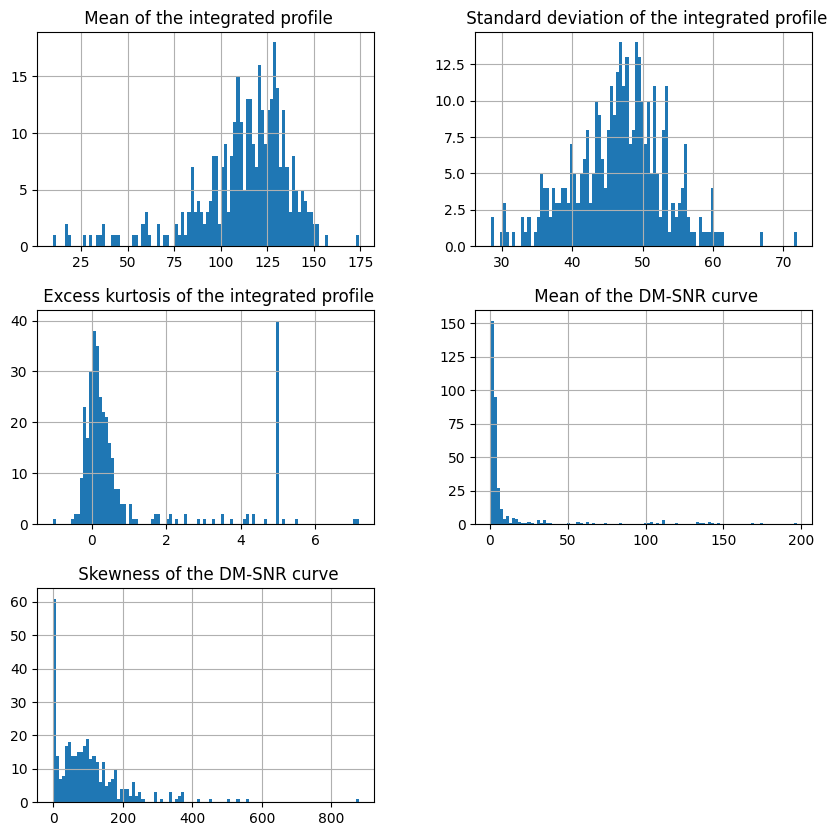

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))
hist = input.hist(bins=100, ax= ax)

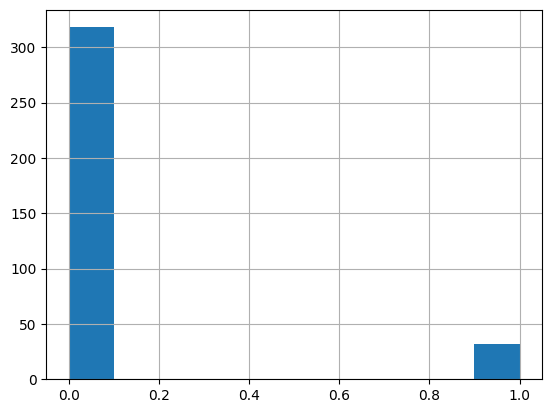

In [187]:
hist2 = y.hist()

<Axes: >

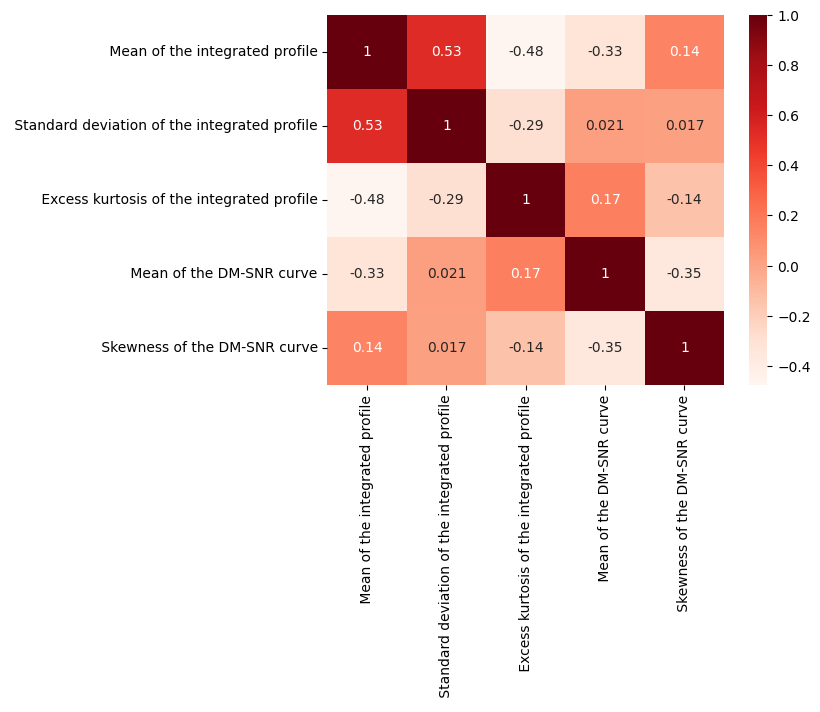

In [188]:
corelation_matrix = input.corr()
sns.heatmap(corelation_matrix, cmap="Reds", annot=True)

The one feature left with less than -.6 corelation is *Excess kurtosis of the integrated profile*




In [189]:
input = input.drop(' Excess kurtosis of the integrated profile', axis=1)

<Axes: >

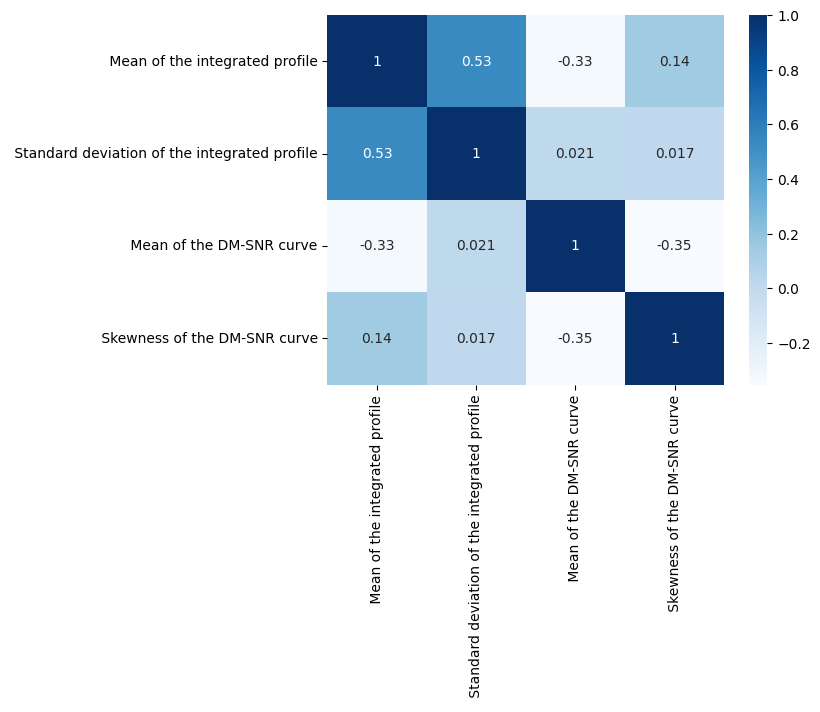

In [190]:
corelation_matrix = input.corr()
sns.heatmap(corelation_matrix, cmap="Blues", annot=True)

# Implementing *Quantum Support Vector Machine* using Qiskit

In [191]:
X_train, X_test, y_train, y_test = train_test_split(input, y, test_size=0.3, random_state=42)

In [192]:
n_qubit = len(X_train.columns)
n_qubit

4

In [193]:
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 42

feature_map = ZFeatureMap(feature_dimension=n_qubit, reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)

In [194]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

from qiskit_machine_learning.datasets import ad_hoc_data
import sklearn.metrics as metrics

# Convert X_train to numeric and then to float
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)

# Convert y_train to numeric and then to float
y_train = y_train.apply(pd.to_numeric, errors='coerce').astype(float)

# Convert X_test to numeric and then to float as well
X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)  # Apply to X_test

# Use QSVC for classification
qsvc = QSVC(quantum_kernel=qkernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.8857142857142857


# Confusion for validation of Model

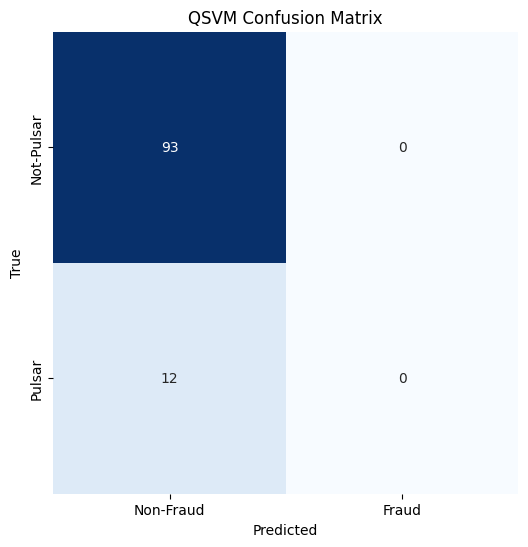

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_qsvm = confusion_matrix(y_test, labels_test)

# Plot for QSVM
plt.figure(figsize=(6, 6))
sns.heatmap(cm_qsvm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Not-Pulsar', 'Pulsar'])
plt.title("QSVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()